# RNN Model for Stock Price Prediction

This README provides a detailed description of the implementation of a Recurrent Neural Network (RNN) model for predicting stock prices based on historical data. Unlike Convolutional Neural Networks (CNNs) which primarily capture spatial hierarchies in data, RNNs are well-suited to time series forecasting due to their ability to maintain a memory of previous inputs through hidden states. This makes RNNs ideal for problems where the sequence and continuity of the data are critical.

## Model Architecture

The RNN model implemented in PyTorch is structured specifically to optimize predictions for stock prices:

- **RNN Layers**: Utilizes basic RNN cells to process sequences of historical stock prices. The RNN handles input data sequentially, updating its hidden states based on the information from the current input and the previous hidden state.
- **Input Layer**: Receives sequences of historical data points, each representing stock prices at different times.
- **Output Layer**: Incorporates a linear layer that receives the last output of the RNN sequence to predict future stock prices.
- **Loss Function and Optimizer**: The model employs Mean Squared Error (MSE) to measure prediction accuracy and uses an Adam optimizer for efficient weight adjustments based on the calculated gradients.

## Forecasting Process

The approach to forecasting with the RNN model involves a series of essential steps:

1. **Data Preparation**: Similar to CNNs, data for RNNs needs to be properly scaled and formatted. However, RNNs require sequences to maintain temporal information.
2. **Model Initialization**: Set up includes defining the number of RNN layers, hidden units, and initializing model parameters.
3. **Training Loop**: Training involves feeding sequences of data into the model, calculating loss at each epoch, and updating model weights to minimize prediction errors.
4. **Evaluation**: The model is tested on a separate validation set to ensure that it generalizes well beyond the training data.
5. **Visualization**: Results of the model predictions versus actual stock prices are plotted to visually assess model performance.

## Differences Between CNN and RNN Models

- **Temporal Dependency Handling**: CNNs capture spatial dependencies within a sequence by applying filters across the data, which can be efficient but might overlook some temporal nuances. In contrast, RNNs are designed to handle sequences by considering the temporal order of data, which is pivotal in stock price predictions.
- **Architecture**: CNNs typically use convolutional and pooling layers to process data, which are absent in RNNs. Instead, RNNs use layers of recurrent cells that process data sequentially and store information in hidden states.
- **Training Dynamics**: RNNs can be more challenging to train due to issues like vanishing and exploding gradients, unlike CNNs which are generally more stable due to their feedforward nature.

## Usage Instructions

To use the RNN model for stock price forecasting, follow these steps:

1. **Load Data**: Import your dataset consisting of historical stock price data.
2. **Set Model Parameters**: Configure settings such as the number of layers, size of the hidden units, and learning rate as needed.
3. **Prepare Data**: Normalize the dataset and arrange it into training and testing sequences.
4. **Instantiate and Train the Model**: Create an instance of the RNN model and start the training process.
5. **Evaluate and Visualize**: Once training is complete, evaluate the model on the test data and visualize the predictions against the actual stock prices.

## Requirements

- Python 3.x
- PyTorch
- NumPy
- Matplotlib or Plotly (for visualization)

This RNN model provides a robust framework for financial analysts and data scientists aiming to leverage the sequential nature of stock prices for prediction. By effectively utilizing the inherent temporal patterns in historical data, the RNN model helps in making informed forecasts crucial for successful trading and investment strategies.

In [7]:
# !pip install yfinance tensorflow keras numpy matplotlib seaborn tqdm scikit-learn graphviz

In [2]:
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import plotly.graph_objects as go


# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [3]:
# stock configs
ticker = ['TSLA']
start_date = '2014-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

In [4]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(2520, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-04-01,13.934667,14.544000,13.905333,14.464667,110571000,0.0,0.0
1,2014-04-02,14.666667,15.392667,14.536667,15.352667,161734500,0.0,0.0
2,2014-04-03,15.353333,15.715333,14.800000,15.026667,163855500,0.0,0.0
3,2014-04-04,15.067333,15.218000,14.083333,14.148667,170184000,0.0,0.0
4,2014-04-07,13.720667,14.413333,13.567333,13.834667,147832500,0.0,0.0


# Model Implementation

Below we implement the model, first we separate the data into a train-test split.  For this LSTM model, we will leverage continuous windows of time for training and test data.


In [5]:
scaler = MinMaxScaler()
minmax = scaler.fit(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(data.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.012205
1,0.014423
2,0.013608
3,0.011415
4,0.010631


In [6]:
simulation_size = 5
lookback = 30
train_len = int(included_days * train_size)
test_len = included_days - train_len

df_train = df_log.iloc[:train_len]
df_test = df_log.iloc[train_len:]


def create_dataset(X, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X)-look_back):
        a = X[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(X[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

lookback = 30  # this variable was previously defined but not used in your example
X_train, y_train = create_dataset(df_train.values, lookback)
X_test, y_test = create_dataset(df_test.values, lookback)

# Adjust for LSTM input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, learning_rate, num_layers, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        
        # Linear Layer
        self.linear = nn.Linear(hidden_size, output_size)
        
        # Loss Function and Optimizer
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, hidden):
        # RNN layer
        out, hidden = self.rnn(x, hidden)
        
        # Taking the last time step output
        out = self.linear(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

def calculate_accuracy(real, predict):
    real = torch.tensor(real) + 1
    predict = torch.tensor(predict) + 1
    percentage = 1 - torch.sqrt(torch.mean(torch.pow((real - predict) / real)))
    return percentage.item() * 100

In [26]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [38]:
num_layers = 10
size_layer = 128
timestamp = 5
epoch = 100
dropout_rate = 0.8
future_day = 60
learning_rate = 0.01

In [35]:
def forecast(model, X_train, y_train, X_test, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Convert data to tensors and load to the designated device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)

    for epoch in range(epochs):
        model.optimizer.zero_grad()
        hidden = model.init_hidden(X_train_tensor.size(0))
        hidden = hidden.to(device)

        outputs, hidden = model(X_train_tensor, hidden)
        loss = model.loss_fn(outputs, y_train_tensor)
        loss.backward()
        model.optimizer.step()
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch} Loss {loss.item()}')

    # Evaluation
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    hidden = model.init_hidden(X_test_tensor.size(0))
    hidden = hidden.to(device)

    with torch.no_grad():
        test_pred, hidden = model(X_test_tensor, hidden)
    
    return test_pred.squeeze().cpu().numpy()

In [39]:
def run_model_iterations(n_iterations, X_train, y_train, X_test):
    predictions = []
    for _ in range(n_iterations):
        # Initialize the model
        model = Model(learning_rate=0.01, num_layers=1, output_size=1, input_size=1, hidden_size=128)
        
        # Train and predict
        preds = forecast(model, X_train, y_train, X_test, epoch)
        arr = scaler.inverse_transform(preds.reshape(-1, 1)).tolist()
        arr = [p[0] if isinstance(p, list) else p for p in arr]
        predictions.append(arr)
    
    return predictions

In [40]:
# Run the model multiple times
from datetime import datetime, timedelta 
n_iterations = 5
test_start_date = datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=test_len - 1)
model_predictions = run_model_iterations(n_iterations, X_train, y_train, X_test)
actual_data = y_test.flatten()
dates = pd.date_range(start=test_start_date, periods=len(y_test), freq='D')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 Loss 0.06264612078666687
Epoch 20 Loss 0.06987074762582779
Epoch 40 Loss 0.060489390045404434
Epoch 60 Loss 0.048805978149175644
Epoch 80 Loss 0.04142754152417183


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 Loss 0.06834112107753754
Epoch 20 Loss 0.19219127297401428
Epoch 40 Loss 0.09582497924566269
Epoch 60 Loss 0.06477020680904388
Epoch 80 Loss 0.05612597241997719


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 Loss 0.09613217413425446
Epoch 20 Loss 0.36453184485435486
Epoch 40 Loss 0.04909057542681694
Epoch 60 Loss 0.03533356636762619
Epoch 80 Loss 0.00774778937920928


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 Loss 0.08068437874317169
Epoch 20 Loss 0.14698217809200287
Epoch 40 Loss 0.058175813406705856
Epoch 60 Loss 0.05275479331612587
Epoch 80 Loss 0.04408425837755203


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0 Loss 0.08298365771770477
Epoch 20 Loss 0.06490489840507507
Epoch 40 Loss 0.07448380440473557
Epoch 60 Loss 0.05769079551100731
Epoch 80 Loss 0.05893956124782562


In [41]:
model_predictions = [[0] * 30 + pred for pred in model_predictions]
print(model_predictions[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 121.53660583496094, 118.07185363769531, 120.93183898925781, 116.72846984863281, 116.32357025146484, 112.2650375366211, 112.7824935913086, 108.73696899414062, 110.95817565917969, 115.28693389892578, 120.2800064086914, 120.7950210571289, 119.40531921386719, 122.17460632324219, 116.37117004394531, 116.76399230957031, 116.8086929321289, 117.6362075805664, 117.16669464111328, 115.2142562866211, 110.74340057373047, 111.5316390991211, 114.64027404785156, 109.92667388916016, 110.40116119384766, 115.52288055419922, 115.90682220458984, 115.79877471923828, 118.47309875488281, 118.57162475585938, 115.5091323852539, 114.0771484375, 112.81938171386719, 113.38996124267578, 114.92073822021484, 114.7691650390625, 118.06159973144531, 120.00171661376953, 116.0953598022461, 115.3504638671875, 116.1856918334961, 116.62478637695312, 117.14285278320312, 117.32268524169922, 118.6266860961914, 119.27659606933594, 125.543

In [42]:

# Creating traces for the actual and predicted stock prices
trace_actual = go.Scatter(
    x=dates,
    y=data['Close'].iloc[train_len:].values,
    mode='lines',
    name='Actual Price',
    line=dict(color='blue', width=2)
)

traces_predicted = []
for i, preds in enumerate(model_predictions):
    trace_predicted = go.Scatter(
        x=dates,
        y=preds,
        mode='lines',
        name=f'Predicted Price (Iteration {i+1})',
        line=dict(color=f'rgba(255, 0, 0, {1 - i*0.12})', dash='dot', width=2)  # Adjust opacity for clarity
    )
    traces_predicted.append(trace_predicted)

# Create the layout and figure
layout = go.Layout(
    title='Stock Price Prediction (During Test Period)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    template='plotly_dark'
)

fig = go.Figure(data=[trace_actual] + traces_predicted, layout=layout)
fig.show()

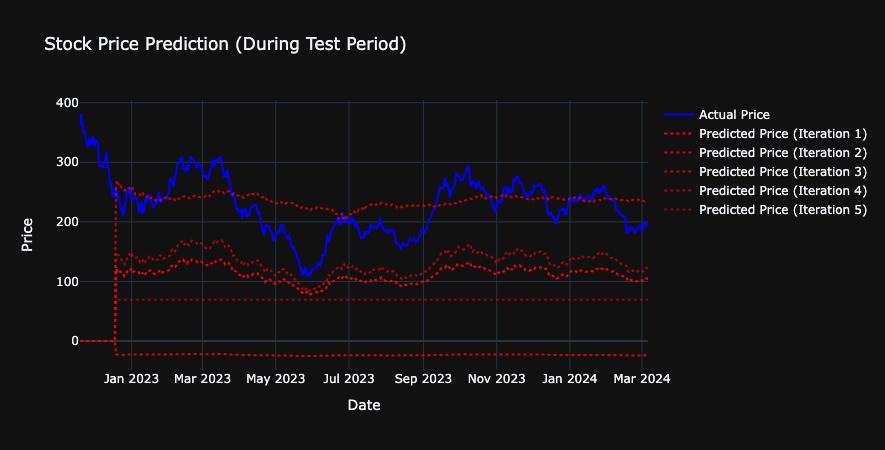